In [1]:
%load_ext autoreload
%autoreload 2

from oads_access.oads_access import OADS_Access, OADSImageDataset
from oads_access.oads_style_transfer import UnNormalize
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from pytorch_utils.pytorch_utils import collate_fn, ToJpeg
import torchvision
from torchvision import transforms
from copy import deepcopy
import matplotlib.pyplot as plt

/home/nmuller/.conda/envs/ccnn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_workers = 1
home_path = os.path.expanduser('~')
batch_size = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [3]:
oads = OADS_Access(basedir=f'{home_path}/projects/data/oads', n_processes=num_workers, use_jpeg=True, jpeg_quality=40)
oads_raw = deepcopy(oads)
oads_raw.use_jpeg = False

In [4]:
train_ids, val_ids, test_ids = oads.get_train_val_test_split_indices(use_crops=True, random_state=None, shuffle=True)

In [5]:
class_index_mapping = {}
index_label_mapping = {}
for index, (key, item) in enumerate(list(oads.get_class_mapping().items())):
    class_index_mapping[key] = index
    index_label_mapping[index] = item

In [6]:
from albumentations.augmentations.transforms import ImageCompression
import numpy as np

class ToJpegProbabilistic(ToJpeg):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.rng = np.random.default_rng()

    def __call__(self, sample):
        quality = self.rng.integers(low=10, high=40)
        # print(quality)

        jpeg = ImageCompression(quality_lower=0, quality_upper=quality, p=self.p, always_apply=True)
        sample = np.array(sample)
        jpeg = jpeg.apply(sample, quality=quality)
        
        if self.resize:
            jpeg = Image.fromarray(jpeg)
            width = jpeg.width
            height = jpeg.height
            jpeg = np.array(jpeg.resize((width // self.resize_factor, height // self.resize_factor)))
        return jpeg

In [7]:
mean = [0.3410, 0.3123, 0.2787]
std = [0.2362, 0.2252, 0.2162]
size = (400, 400)

transform_list = []
transform_list.append(transforms.Resize(size))
transform_list.append(ToJpegProbabilistic(quality=40, p=1.0))
transform_list.append(transforms.ToTensor())
if mean is not None and std is not None:
    transform_list.append(transforms.Normalize(mean, std))
transform = transforms.Compose(transform_list)

transform_list_raw = []
transform_list_raw.append(transforms.Resize(size))
transform_list_raw.append(transforms.ToTensor())
if mean is not None and std is not None:
    transform_list_raw.append(transforms.Normalize(mean, std))
transform_raw = transforms.Compose(transform_list_raw)

In [8]:
unloader = transforms.ToPILImage()
unnorm = UnNormalize(mean=mean, std=std)

show = lambda x: unloader(unnorm(x))

In [9]:
# traindataset = OADSImageDataset(oads_access=oads, item_ids=train_ids, use_crops=True, return_index=True,
#                                 class_index_mapping=class_index_mapping, transform=transform, device=device)
# valdataset = OADSImageDataset(oads_access=oads, item_ids=val_ids, use_crops=True, return_index=True,
#                                 class_index_mapping=class_index_mapping, transform=transform, device=device)
testdataset = OADSImageDataset(oads_access=oads, item_ids=test_ids, use_crops=True, return_index=True,
                                class_index_mapping=class_index_mapping, transform=transform, device=device)
testdataset_raw = OADSImageDataset(oads_access=oads_raw, item_ids=test_ids, use_crops=True, return_index=True,
                                class_index_mapping=class_index_mapping, transform=transform_raw, device=device)

In [10]:
# trainloader = DataLoader(traindataset, collate_fn=collate_fn,
#                             batch_size=batch_size, shuffle=True, num_workers=oads.n_processes)
# valloader = DataLoader(valdataset, collate_fn=collate_fn,
#                         batch_size=batch_size, shuffle=False, num_workers=oads.n_processes)
testloader = DataLoader(testdataset, collate_fn=collate_fn,
                        batch_size=batch_size, shuffle=False, num_workers=oads.n_processes)
testloader_raw = DataLoader(testdataset_raw, collate_fn=collate_fn,
                        batch_size=batch_size, shuffle=False, num_workers=oads.n_processes)

In [11]:
from torchvision.models import resnet50

model = resnet50()
model.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=model.conv1.out_channels, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
model.fc = torch.nn.Linear(in_features=2048, out_features=21, bias=True)

In [18]:
criterion = nn.CrossEntropyLoss()

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
_iter = iter(testloader)
_iter_raw = iter(testloader_raw)

In [20]:
item = next(_iter)
item_raw = next(_iter_raw)

In [30]:
scores = model(item[0])

In [31]:
loss = criterion(scores, item[1])
loss

tensor(0.6216, grad_fn=<NllLossBackward0>)

In [28]:
loss.backward()

In [29]:
optimizer.step()

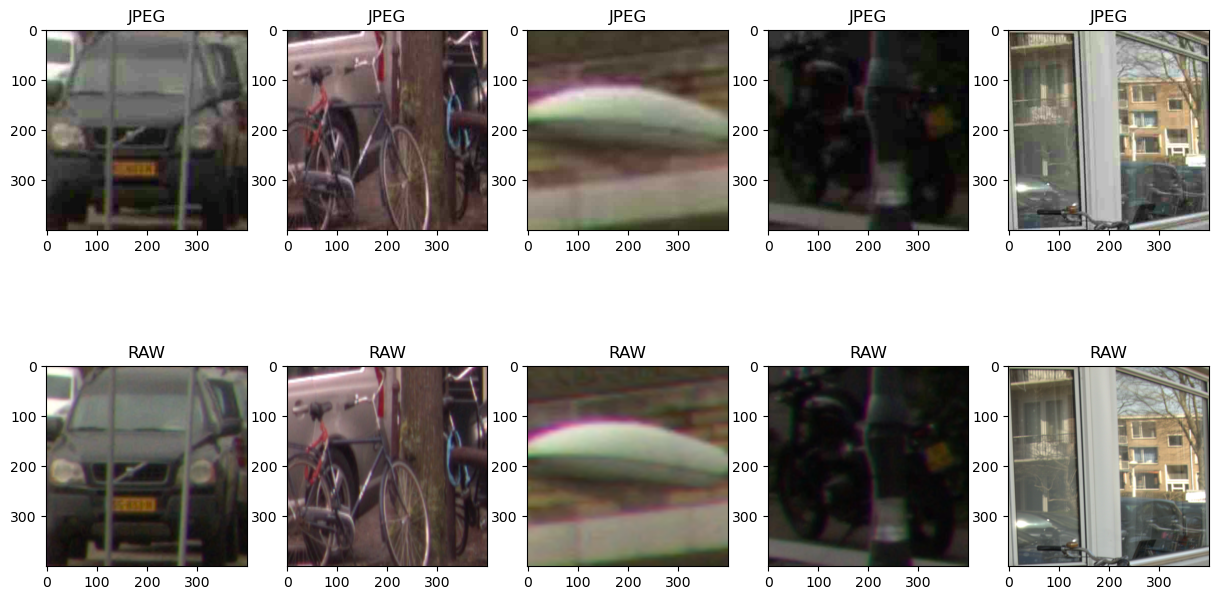

In [129]:
n = 5

fig, ax = plt.subplots(2,n, figsize=(15,8))

for index in range(n):
    item = next(_iter)
    item_raw = next(_iter_raw)

    img = show(item[0][0])
    img_raw = show(item_raw[0][0])

    ax[0, index].imshow(img)
    ax[0, index].set_title('JPEG')
    ax[1, index].imshow(img_raw)
    ax[1, index].set_title('RAW')

plt.show()